In [ ]:
# !pip install transformers
# !pip install lightgbm==3.2.1
!pip install pymorphy2

In [ ]:
import re
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from functools import lru_cache
from multiprocessing import Pool
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor, Ridge
from lightgbm import LGBMClassifier, LGBMRegressor
from gensim.models import Word2Vec
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer, AutoModelForMaskedLM,
    BertForSequenceClassification, BertTokenizer)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
import logging
import multiprocessing
import gensim
from time import time

# import fasttext.util
# fasttext.util.download_model('ru', if_exists='ignore')
# ft = fasttext.load_model('cc.ru.300.bin')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/del-experiment-stock-price/stock_price.csv
/kaggle/input/sber-price-hist/---.-ru0009029540.xlsx
/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv
/kaggle/input/sentiment-scores-new/title_sentiment.xlsx
/kaggle/input/sentiment-scores-new/lemmas_sentiment.xlsx
/kaggle/input/bankdefaultsinrussia/dataset.csv
/kaggle/input/test-to-delete/test.json
/kaggle/input/stocks/BSPB.xlsx
/kaggle/input/stocks/VTBR.xlsx
/kaggle/input/stocks/SBER.xlsx


# II. DL

*Prediciton of news influence on bank return and risk indicators*

Goals:
- to analyze news data, combine different sources of information
- initially, to distinguish financial/economic news data from other types; later, to parse more these types of news
- to identify metrics how to evaluate model quality
- to experiment with LLM models
- to add predicted default by ML model as features for DL model + possibly, add other features used for learning in Part I  

## 1. News Dataset

### 1.1. News from 2010 to 2017
*- I use titles of news but the whole text also might be useful!*

In [ ]:
# lenta-ru-news.csv has 739351 rows in reality, but we filter news later 2010
df_news = pd.read_csv('/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv', delimiter=',')
df_news['date'] = pd.to_datetime(df_news['date'])
df_news = df_news.loc[(df_news['date'] >= '2009-12-01') &
                      (df_news['date'] <= '2017-12-01')].reset_index(drop=True)

df_news['sym_len'] = df_news.title.apply(len)
df_news['word_len'] = df_news.title.apply(lambda x: len(x.split()))

df_news = df_news[df_news['topic'].isin(['Экономика', 'Мир', 'Россия'])]
# df_news.to_csv('lenta-ru-news-2010-to-2017.csv', index=False)

/tmp/ipykernel_129/552543655.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_news = pd.read_csv('/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv', delimiter=',')


### 1.2. Lemmatizer for news

In [ ]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

mystopwords = stopwords.words('russian')
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    return ' '.join(remove_stopwords(lemmas))

with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df_news['title']), total=len(df_news)))

df_news['lemmas'] = lemmas

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 168333/168333 [02:55<00:00, 956.58it/s] 


### 1.3. Target features

#### 1.3.1. Price History from 2010 to 2017
3 stocks

In [ ]:
# prepare regression data
stocks_files = ['SBER.xlsx', 'VTBR.xlsx','BSPB.xlsx']
df_stocks_targets_reg = pd.DataFrame(
    {'date': pd.read_excel(f'/kaggle/input/stocks/{stocks_files[0]}', header=1)['Дата'].tolist()})

# filter for news period
df_stocks_targets_reg = df_stocks_targets_reg.loc[(df_stocks_targets_reg['date'] >= '2009-11-01') &
                                                  (df_stocks_targets_reg['date'] <= '2017-12-01')].dropna()

# prepare classification data
df_stocks_targets_cls = df_stocks_targets_reg.copy()

# prepare extra data to experiment with returns
df_stocks_returns_reg = df_stocks_targets_reg.copy()

# prepare extra data for classification of major changes (+- 2% of yesterday price)
df_stocks_major_cls = df_stocks_targets_reg.copy()


for f in stocks_files:
    df_stock = pd.read_excel(f'/kaggle/input/stocks/{f}', header=1).rename(columns={'Дата': 'date', 'Avg': f[:4]})
    df_stock.loc[df_stock[f[:4]].isna(), f[:4]] = df_stock.loc[df_stock[f[:4]].isna(), 'Закрытие']
    df_stocks_targets_reg = df_stocks_targets_reg.merge(df_stock[['date', f[:4]]], how='left', on='date')
    df_stocks_targets_reg = df_stocks_targets_reg.dropna()

    df_stock['up_down'] = np.where(df_stock[f[:4]].diff() < 0, -1, 1)
    df_stocks_targets_cls = df_stocks_targets_cls.merge(df_stock[['date', 'up_down']], how='left', on='date')\
                                                 .rename(columns={'up_down': f[:4]})

    df_stocks_returns_reg[f[:4]] = df_stocks_targets_reg[f[:4]].pct_change(fill_method=None)
    df_stocks_returns_reg = df_stocks_returns_reg.dropna()

    df_stock['up_down_class'] = np.select(
        condlist=[
            (df_stock[f[:4]].diff() < -2),
            (df_stock[f[:4]].diff() >= -2) & (df_stock[f[:4]].diff() < 0),
            (df_stock[f[:4]].diff() >= 0) & (df_stock[f[:4]].diff() <= 2),
            (df_stock[f[:4]].diff() > 2)],
        choicelist=['down', 'small down', 'small up', 'up'], default='small down')
    df_stocks_major_cls = df_stocks_major_cls.merge(df_stock[['date', 'up_down_class']], how='left', on='date')\
                                             .rename(columns={'up_down_class': f[:4]})

In [ ]:
print('regression data\n', df_stocks_targets_reg.head())
print('\nclassification data\n', df_stocks_targets_cls.head())
print('\nregression data with returns\n', df_stocks_returns_reg.head())
print('\nclassification of major changes (+- 2% of yesterday price)\n:', df_stocks_major_cls.head())

regression data
         date   SBER    VTBR   BSPB
0 2010-01-11  87.30  0.0740  84.91
1 2010-01-12  85.85  0.0727  82.63
2 2010-01-13  85.93  0.0737  86.01
3 2010-01-14  87.43  0.0751  95.75
4 2010-01-15  88.01  0.0746  96.98

classification data
         date  SBER  VTBR  BSPB
0 2010-01-11     1     1     1
1 2010-01-12    -1    -1    -1
2 2010-01-13     1     1     1
3 2010-01-14     1     1     1
4 2010-01-15     1    -1     1

regression data with returns
         date      SBER      VTBR      BSPB
1 2010-01-12 -0.016609 -0.017568 -0.026852
2 2010-01-13  0.000932  0.013755  0.040905
3 2010-01-14  0.017456  0.018996  0.113243
4 2010-01-15  0.006634 -0.006658  0.012846
5 2010-01-18  0.018180  0.004021  0.039390

classification of major changes (+- 2% of yesterday price)
:         date        SBER        VTBR      BSPB
0 2010-01-11  small down    small up  small up
1 2010-01-12  small down  small down      down
2 2010-01-13    small up    small up        up
3 2010-01-14    small up  

#### 1.4.2. Banks' indicators data (`bankdefaultsinrussia`)

In [ ]:
df = pd.read_csv('/kaggle/input/bankdefaultsinrussia/dataset.csv')
df = df.dropna().reset_index(drop=True)
df['дата'] = pd.to_datetime(df['дата'])
df = df.astype({'лицензия': 'int', 'default': 'int', 'msk_spb': 'int'})
df = df.rename(columns={'лицензия': 'licence_num', 'дата': 'date'})

# feature engineering
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = pd.DatetimeIndex(df['date']).dayofweek
# df['yearmonth'] = df.apply(lambda row: 100 * row['year'] + row['month'], axis = 1)

df['n_reports'] = df.groupby('licence_num')['licence_num'].transform('count')
df['occurence'] = df.groupby(['licence_num']).cumcount()+1

*- let's use some of the features as target*

In [ ]:
df_indicators = df[['licence_num', 'date', 'ROA', 'ROE', 'net_assets', 'occurence']]
df_indicators.sample(5)

,licence_num,date,ROA,ROE,net_assets,occurence
56902,3172,2014-03-01,168.0,717.0,4182149.0,49
31594,2209,2017-09-01,1818.0,18857.0,10181285.0,92
52574,3006,2011-10-01,-215.0,-588.0,929882.0,19
60070,3252,2014-07-01,216.0,2333.0,167420224.0,47
17496,1194,2010-05-01,184.0,1661.0,23814980.0,4


### 1.3. Merge data and generate features
Datasets list:
* `df_news` - full news dataset
* `df_stocks_targets_cls` - timeseries with stocks price changes as targets for classification
* `df_stocks_major_cls` - timeseries with degrees of stocks price changes as targets for classification
* `df_stocks_targets_reg` - timeseries with stocks prices as targets for regression
* `df_stocks_targets_reg` - timeseries with stocks returns as targets for regression
* `df_indicators` - timeseries with different business indicators as targets for regression

Each training datasets will consist of:
1. Shifts for last 10 periods - input size `(10, 1)`
2. (if it's part of experiment) Sentiment score - input size `(11, 1)`
3. (if it's part of experiment) Embeddings - input size `(10 + embeddings shape, 1)`

In [ ]:
# for data without tokenizers and sentiment
def add_shifts_and_filter(df, target, multi_bank_series_feature=None, date_feature='date', dropna=True,
                          reg_data_for_cls_task=None):
    data = df.copy()

    if not multi_bank_series_feature:
        if reg_data_for_cls_task is None:
            for i in range(1, 11):
                data[f'{target}_shift{i}'] = data[target].shift(i)
        else:
            for i in range(1, 11):
                data[f'{target}_shift{i}'] = reg_data_for_cls_task[target].shift(i)
        data = data.loc[:, [date_feature,
                            *data.columns[data.columns.str.contains(target)].tolist()]]

    else:
        data['occurence'] = data.groupby([multi_bank_series_feature]).cumcount() + 1
        for i in range(1, 11):
            data['prev'] = data['occurence'] - i
            data = data.merge(data[[multi_bank_series_feature, target, 'occurence']],
                              how='left', left_on=[multi_bank_series_feature, 'prev'],
                              right_on=[multi_bank_series_feature, 'occurence'],
                              suffixes=('', f'_shift{i}')).drop(columns=['prev', f'occurence_shift{i}'])
        data = data.loc[:, [multi_bank_series_feature, date_feature,
                            *data.columns[data.columns.str.contains(target)].tolist()]]

    if dropna:
        return data.dropna()
    else:
        return data

In [ ]:
# for data with tokenizers and sentiment
def aggregate_and_merge_daily(data_news, data_target, date_field='date',
                              lemmas_field='lemmas', dropna=True):
    dts = data_news[date_field].unique().tolist()
    date_words = pd.DataFrame({date_field: [], lemmas_field: []})

    for d in tqdm(dts):
        day_lemmas = [' '.join(data_news.loc[data_news[date_field] == d, lemmas_field].values.tolist())]
        new_date_words = pd.DataFrame({date_field: [d], lemmas_field: day_lemmas})
        if date_words.empty:
            date_words = new_date_words
        else:
            date_words = pd.concat([date_words, new_date_words], axis=0, ignore_index=True)

    #     date_words['sym_len'] = date_words.lemmas.apply(len)
    #     date_words['word_len'] = date_words.lemmas.apply(lambda x: len(x.split()))

    date_words = date_words.merge(data_target, how='left', on=date_field)

    if dropna:
        return date_words.dropna()
    else:
        return date_words

In [ ]:
def transform_target_series(data, target_col, scaler, date_feature='date'):
    if scaler is not None:
        transformed_data = scaler.fit_transform(data[target_col].to_numpy().reshape(-1, 1)).squeeze()
        transformed_data = pd.Series(transformed_data, name=target_col)
    else:
        transformed_data = data[target_col]
    return pd.DataFrame({date_feature: data[date_feature].values, target_col: transformed_data}), scaler

In [ ]:
# add_shifts_and_filter(df_stocks_targets_reg, 'SBER')
# add_shifts_and_filter(df_stocks_targets_cls, 'SBER', reg_data_for_cls_task=df_stocks_targets_reg)
# add_shifts_and_filter(df_indicators, 'ROE', multi_bank_series_feature='licence_num')
searchfor = ['банк', 'втб', 'сбер', 'плат', 'кредит', 'депозит', 'долг',
             'доллар', 'рубль', 'нефть', 'доход', 'экономика', 'оценка', 'бизнес', 'правительство',
             'дефолт', 'компания', 'альфа', 'акционер', 'клиент', 'актив', 'суд', 'обвал']
df_news_filtered = df_news[df_news['lemmas'].str.lower().str.contains('|'.join(searchfor))].reset_index(drop=True)
df_news_filtered = df_news_filtered.merge(df_news[(df_news.topic == 'Экономика') & (~df_news.date.isin(df_news_filtered.date))]\
                                          .groupby('date', as_index=False)['title'].first(),
                                          how='left', on='date')
date_words_reg = aggregate_and_merge_daily(df_news_filtered, df_stocks_targets_reg).reset_index(drop=True)
date_words_cls = aggregate_and_merge_daily(df_news_filtered, df_stocks_targets_cls).reset_index(drop=True)

100%|██████████| 2763/2763 [00:04<00:00, 579.86it/s]


## 2. Models and Vectorizers

2 types of tasks can be solved with this data:

> CLASSIFICATION
>
> *- prediction of target movement direction - up/down*

> REGRESSION
>
> *- prediction of future target value*

All tasks data will be considered in several ways:
* different targets - stock price (3 banks) / banks' business indicators from data of ML part (defined above)
* Classic models / DL models
* with / without sentiment from DL
* without tokenizer / TF-IDF / Word2Vec

The result of each task for every considered target will be presented in this table:

| | | without sentiment | | | with sentiment | |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| **model** | **no text data** | **TF-IDF** | **Word2Vec** | **without tokenizer** | **TF-IDF**     | **Word2Vec** |
| ... | ... | ... | ... | ... | ... |


### 2.1. Models

#### 2.1.1. Classic Models

In [ ]:
# CLASSIFICATION
def get_ml_models_cls(task_type="GPU"):
    model_lr = LogisticRegression(random_state=42, max_iter=5000, warm_start=True, verbose=False, n_jobs=-1)
    model_svc = LinearSVC(loss="squared_hinge", verbose=False, max_iter=5000, random_state=42, penalty='l2', dual=False)
    model_rf = RandomForestClassifier(random_state=42, verbose=False, n_jobs=-1)
    model_cb = CatBoostClassifier(random_seed=7, silent=True, task_type=task_type)
    model_lgbm = LGBMClassifier(n_estimators=300, verbose=0, n_jobs=-1)
    models_dict = {'LogisticRegression': model_lr,
                   'LinearSVC': model_svc,
                   'RandomForestClassifier': model_rf,
                   'CatBoostClassifier': model_cb,
                   'LGBMClassifier': model_lgbm}

    result_dict = {'LogisticRegression': {'accuracy': [], 'predictions': []},
                   'LinearSVC': {'accuracy': [], 'predictions': []},
                   'RandomForestClassifier': {'accuracy': [], 'predictions': []},
                   'CatBoostClassifier': {'accuracy': [], 'predictions': []},
                   'LGBMClassifier': {'accuracy': [], 'predictions': []}}
    return models_dict, result_dict

In [ ]:
# REGRESSION
def get_ml_models_reg(task_type="GPU", verb=False):
    model_lr_reg = Ridge(random_state=42, max_iter=5000)
    model_svc_reg = LinearSVR(verbose=verb, max_iter=5000)
    model_sgd_reg = SGDRegressor(verbose=verb, max_iter=5000, warm_start=True, loss='squared_error')
    model_cb_reg = CatBoostRegressor(random_seed=7, silent=not verb, task_type=task_type, iterations=1000)
    model_lgbm_reg = LGBMRegressor(n_estimators=300, verbose=int(verb), n_jobs=-1)
    models_dict = {'Ridge': model_lr_reg,
                   'LinearSVR': model_svc_reg,
                   'SGDRegressor': model_sgd_reg,
                   'CatBoostRegressor': model_cb_reg,
                   'LGBMRegressor': model_lgbm_reg}

    result_dict = {'Ridge': {'mse': 0, 'mae': 0, 'mape': 0, 'predictions': []},
                   'LinearSVR': {'mse': 0, 'mae': 0, 'mape': 0, 'predictions': []},
                   'SGDRegressor': {'mse': 0, 'mae': 0, 'mape': 0, 'predictions': []},
                   'CatBoostRegressor': {'mse': 0, 'mae': 0, 'mape': 0, 'predictions': []},
                   'LGBMRegressor': {'mse': 0, 'mae': 0, 'mape': 0, 'predictions': []}}
    return models_dict, result_dict

#### 2.1.2. DL model
I will construct LSTM network that offered in this [source](https://arxiv.org/pdf/2211.07392v1#page=2)

------------------------------------------------------------------------

In [ ]:
def train_test_split_timeseries(stock_data, target_col, scaler, window, test_size=100):
    target_col = target_col if isinstance(target_col, list) else [target_col]
    train = stock_data.get(target_col).values[:-test_size]
    test = stock_data.get(target_col).values[-test_size:]
    train, test = scaler.fit_transform(train), scaler.fit_transform(test)

    X_train, X_test = [], []
    for i in range(train.shape[0] - window):
        X_train.append(train[i : i + window])
    for i in range(test.shape[0] - window):
        X_test.append(test[i : i + window])

    X_test = np.array(X_test).astype(float)
    y_test = np.array(test[window:]).astype(float)
    X_train = np.array(X_train).astype(float)
    y_train = np.array(train[window:]).astype(float)

    return X_train, y_train, X_test, y_test

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=50, batch_first=True)
        self.dropout1 = nn.Dropout(0.15)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=30, batch_first=True)
        self.dropout2 = nn.Dropout(0.05)
        self.lstm3 = nn.LSTM(input_size=30, hidden_size=20, batch_first=True)
        self.dropout3 = nn.Dropout(0.01)
        self.fc = nn.Linear(20, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out, _ = self.lstm3(out)
        out = self.dropout3(out)
        out = out[:, -1, :]  # take the last output of the sequence
        out = self.fc(out)
        return out

In [ ]:
# define training loop
def train_epoch(model, train_loader, criterion, optimizer, window=10, num_sent_features=0, metric='MAPE'):
    train_loss = 0.0
    train_metric = 0.0

    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.view(-1, window+num_sent_features, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss.item()

        if metric == 'MAE':
            train_metric += mean_absolute_error(outputs.cpu().detach().numpy(), targets)
        elif metric == 'MAPE':
            train_metric += mean_absolute_percentage_error(outputs.cpu().detach().numpy(), targets)

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_metric /= len(train_loader)

    return train_loss, train_metric

# define evaluating loop
def eval_epoch(model, test_loader, criterion, scaler, window=10,
               num_sent_features=0, metric='MAPE'):
    predicts = []
    test_loss = 0.0
    test_metric = 0.0
    targets = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(-1, window+num_sent_features, 1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            predicts = outputs.squeeze()
            test_loss += loss.item()
            targets = targets

    test_loss /= len(test_loader)

    predicts = scaler.inverse_transform(predicts.view(-1, 1).numpy()).reshape(-1, 1)
    targets = scaler.inverse_transform(targets.view(-1, 1).numpy()).reshape(-1, 1)

    if metric == 'MAE':
        test_metric += mean_absolute_error(predicts, targets)
    elif metric == 'MAPE':
        test_metric += mean_absolute_percentage_error(predicts, targets)

    return test_loss, test_metric, predicts

# define training epoch
def train_lstm_model(model, train_loader, test_loader, criterion, optimizer,
                     scaler, num_epochs=50, num_sent_features=0):
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    for epoch in range(num_epochs):
        train_loss, train_metric = train_epoch(model, train_loader, criterion, optimizer,
                                               num_sent_features=num_sent_features)
        train_losses.append(train_loss)
        train_metrics.append(train_metric)

        test_loss, test_metric, predicts = eval_epoch(model, test_loader, criterion, scaler,
                                                      num_sent_features=num_sent_features)
        test_losses.append(test_loss)
        test_metrics.append(test_metric)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

        if (epoch+1) % 25 == 0:
            plot_losses(train_losses, test_losses, train_metrics, test_metrics, metric='MAE')

    return train_losses, test_losses, train_metrics, test_metrics, np.array(predicts)

def plot_losses(train_losses, test_losses, train_metric, test_metric, metric='MAPE'):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_metric) + 1), train_metric, label='train')
    axs[1].plot(range(1, len(test_metric) + 1), test_metric, label='test')
    axs[1].set_ylabel(metric)

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

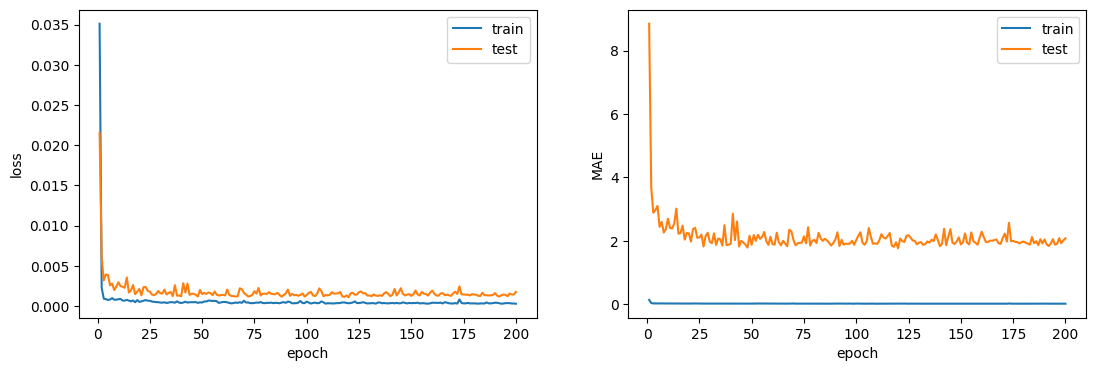

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Hyperparameters
test_size = 100
window = 10
epochs = 200
learning_rate = 0.02

scaler = MinMaxScaler()
stock_data = df_stocks_targets_reg
target_col = ['SBER']
X_train, y_train, X_test, y_test = train_test_split_timeseries(stock_data, target_col, scaler, window, test_size=100)
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# ------ add sentiment
# train_sent_arr = torch.tensor(sent_arr[10:-100], dtype=torch.float32)
# test_sent_arr = torch.tensor(sent_arr[-90:], dtype=torch.float32)
# X_train = torch.cat((X_train, train_sent_arr.unsqueeze(dim=1).unsqueeze(dim=1)), dim=1)
# X_test = torch.cat((X_test, test_sent_arr.unsqueeze(dim=1).unsqueeze(dim=1)), dim=1)
# ------ add sentiment

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# # Instantiate the model, define the loss function and the optimizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(1, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# predictions_no_sent = predictions.copy()
# print(f'Raw data: {train_losses[-1]:.6f}, {test_losses[-1]:.6f}, {train_metrics[-1]:.6f}, {test_metrics[-1]:.6f}')

train_losses, test_losses, train_metrics, test_metrics, predictions = train_lstm_model(
    model, train_loader, test_loader, criterion, optimizer, scaler, num_epochs=epochs, num_sent_features=0)

----

### 2.2. Sentiment feature engineering

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sismetanin/xlm_roberta_large-ru-sentiment-rusentiment')
model = AutoModelForSequenceClassification.from_pretrained("sismetanin/xlm_roberta_large-ru-sentiment-rusentiment")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
X = df_news[df_news.topic.isin(['Экономика'])].reset_index(drop=True)
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 128}

for x in tqdm(X['title'].values):
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        logits = model(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.cpu().detach().numpy().squeeze()),
        )
    }

    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

dff1 = pd.DataFrame()
dff1['date'] = X['date'].reset_index(drop=True)
dff1['title'] = X['title'].reset_index(drop=True)
dff1['preds'] = preds
dff1['preds_proba'] = preds_proba
# dff1.to_excel('lemmas_sentiment.xlsx', index=False)
# dff1.to_excel('title_sentiment.xlsx', index=False)

100%|██████████| 37542/37542 [12:55<00:00, 48.41it/s]


In [ ]:
# X = df_news[df_news.topic.isin(['Экономика'])].reset_index(drop=True)
dff1 = pd.read_excel('/kaggle/input/sentiment-scores-new/lemmas_sentiment.xlsx')

# dff1['date'] = X['date'].reset_index(drop=True)
dff1['preds'] = np.select(
    condlist=[
        dff1['preds'] == 'LABEL_0',
        dff1['preds'] == 'LABEL_1',
        dff1['preds'] == 'LABEL_2',
        dff1['preds'] == 'LABEL_3'],
    choicelist=[
        'negative',
        'neutral',
        'positive',
        'negative'],
    default='neutral')

# the most relevant news
searchfor = ['банк', 'втб', 'сбер', 'плат', 'кредит', 'депозит', 'долг',
             'доллар', 'рубль', 'нефть', 'доход', 'экономика', 'оценка', 'бизнес'
             'дефолт', 'компания', 'альфа', 'акционер', 'клиент', 'актив', 'суд']
dff1_sent = dff1
# [dff1['lemmas'].str.lower().str.contains('|'.join(searchfor))]
dff1_sent.loc[dff1_sent.preds == 'neutral', 'preds_proba'] = 0
dff1_sent.loc[dff1_sent.preds == 'negative', 'preds_proba'] *= (-1)
dff1_sent = dff1_sent.groupby('date', as_index=False).agg({'preds_proba': 'mean'}).sort_values('preds_proba')
dff1_sent['sentiment'] = np.select([dff1_sent.preds_proba < 0, dff1_sent.preds_proba == 0, dff1_sent.preds_proba > 0],
                                   ['negative', 'neutral', 'positive'])

# sentiment feature for each day
sent_arr = pd.DataFrame(df_stocks_targets_reg['date']).merge(dff1_sent, how='left', on='date')['preds_proba'].fillna(0).to_numpy()

### 2.3. Vectorizers

#### 2.3.1. TF-IDF Vectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
# tfidf_vectorizer.fit(date_words_cls['lemmas'].values)

#### 2.3.2. Word2vec

In [ ]:
sentences=[]
sentences.extend(df_news['lemmas'])
sentences=[i.split() for i in sentences]

cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=100,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

vector = w2v_model.wv['газпром']  # get numpy vector of a word
sims = w2v_model.wv.most_similar('газпром', topn=10)  # get other similar words

# [tup[0] for tup in sims]
sims

Time to build vocab: 0.01 mins
Time to train the model: 0.25 mins


[('нафтогаз', 0.9445496201515198),
 ('роснефть', 0.9424133896827698),
 ('транснефть', 0.9141384363174438),
 ('казахстан', 0.9051945209503174),
 ('туркмения', 0.9051777720451355),
 ('новатэк', 0.9006801843643188),
 ('росатом', 0.8994365334510803),
 ('освоение', 0.890393853187561),
 ('лукойл', 0.8881252408027649),
 ('нефтегазовый', 0.8823068141937256)]

In [ ]:
def get_vectors(model,sentence):

    '''Get sentence vectors'''

    vectors=[]
    for i in sentence.split():
        try:
            vectors.append(model.wv[i])
        except:
            continue
    return np.average(vectors,axis=0)


def get_doc_vectors(model,documents,num_features=100):
    # Initialize a counter
    counter = 0
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(documents),num_features),dtype="float32")

    # Loop through the reviews
    for sentence in documents:
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = get_vectors(model,sentence)

        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

## 3. Experiments with stocks data

### 3.1. Classification

#### 3.1.1. BASELINE - No sentiment, no text, just raw history data

In [ ]:
def get_result_dataframe():
    result_dataframe = pd.DataFrame({'sentiment': [], 'tokenizer': [], 'model': [], 'stock_or_indicator': [], 'result': []})
    return result_dataframe

reg_stock_result_dataframe = get_result_dataframe()
reg_indicator_result_dataframe = get_result_dataframe()

In [ ]:
# DataFrame for results
cls_stock_result_dataframe = get_result_dataframe()

scaler = StandardScaler()
encode1 = OneHotEncoder(drop='first', handle_unknown="ignore")
stock_targets = df_stocks_targets_cls.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_cls)
    single_stock_data_reg = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_reg)
    single_stock_data = single_stock_data.merge(single_stock_data_reg, how='left', on='date', suffixes=('', '_reg')).drop(columns=[f'{stock}_reg'])
    X = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_cls = get_ml_models_cls()

    for key in tqdm(models_dict.keys()):
#         if key in ['CatBoostClassifier', 'LGBMClassifier', 'RandomForestClassifier']:
#             X_train = X.loc[:, ~X.columns.str.contains('_reg')]
#             X_test = X_test.loc[:, ~X_test.columns.str.contains('_reg')]
#             column_transformer = ColumnTransformer([
#                 ('encode1', encode1, [f'{stock}_shift{i}' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)
#         else:
        X_train = X
        column_transformer = ColumnTransformer([
            ('encode1', encode1, [f'{stock}_shift{i}' for i in range(1, 11)]),
            ('scaler', scaler, [f'{stock}_shift{i}_reg' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('classify', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cls_stock_result_dataframe = pd.concat([cls_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['no sentiment'],
                                                              'tokenizer': ['no tokenizer'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [acc]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:24<00:00,  4.87s/it]


#### 3.1.2. Add tokenizers
* TF-IDF
* Word2Vec

In [ ]:
scaler = StandardScaler()
encode1 = OneHotEncoder(drop='first', handle_unknown="ignore")
stock_targets = df_stocks_targets_cls.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_cls)
    single_stock_data_reg = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_reg)
    single_stock_data = single_stock_data.merge(single_stock_data_reg, how='left', on='date', suffixes=('', '_reg')).drop(columns=[f'{stock}_reg'])
    single_stock_data = single_stock_data.merge(date_words_cls[['date', 'lemmas']], how='left', on='date')

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_cls = get_ml_models_cls()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('tfidf', tfidf_vectorizer, 'lemmas'),
            ('encode1', encode1, [f'{stock}_shift{i}' for i in range(1, 11)]),
            ('scaler', scaler, [f'{stock}_shift{i}_reg' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('classify', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cls_stock_result_dataframe = pd.concat([cls_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['no sentiment'],
                                                              'tokenizer': ['tf-idf'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [acc]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [03:14<00:00, 38.98s/it]


In [ ]:
scaler = StandardScaler()
encode1 = OneHotEncoder(drop='first', handle_unknown="ignore")
stock_targets = df_stocks_targets_cls.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_cls)
    single_stock_data_reg = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_reg)
    single_stock_data = single_stock_data.merge(single_stock_data_reg, how='left', on='date', suffixes=('', '_reg')).drop(columns=[f'{stock}_reg'])
    single_stock_data = single_stock_data.merge(date_words_cls[['date', 'lemmas']], how='left', on='date')
    X_w2v_vectors = get_doc_vectors(w2v_model, single_stock_data['lemmas'])
    single_stock_data = pd.concat([single_stock_data.reset_index(drop=True), pd.DataFrame(X_w2v_vectors)], axis=1)
    single_stock_data.columns = single_stock_data.columns.astype(str)
    single_stock_data = single_stock_data.loc[:, single_stock_data.columns != 'lemmas']

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_cls = get_ml_models_cls()

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('encode1', encode1, [f'{stock}_shift{i}' for i in range(1, 11)]),
            ('scaler', scaler, [f'{stock}_shift{i}_reg' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('classify', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cls_stock_result_dataframe = pd.concat([cls_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['no sentiment'],
                                                              'tokenizer': ['word2vec'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [acc]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:31<00:00,  6.33s/it]


#### 3.1.3. Add sentiment

In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop=["neutral"], handle_unknown="ignore")
encode1 = OneHotEncoder(drop='first', handle_unknown="ignore")
stock_targets = df_stocks_targets_cls.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_cls)
    single_stock_data_reg = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_reg)
    single_stock_data = single_stock_data.merge(single_stock_data_reg, how='left', on='date', suffixes=('', '_reg')).drop(columns=[f'{stock}_reg'])
    single_stock_data = single_stock_data.merge(dff1_sent, how='left', on='date')
    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_cls = get_ml_models_cls()

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('encode1', encode1, [f'{stock}_shift{i}' for i in range(1, 11)]),
            ("ohe",    encoder, ['sentiment']),
            ('scaler', scaler, [f'{stock}_shift{i}_reg' for i in range(1, 11)]),
        ], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('classify', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cls_stock_result_dataframe = pd.concat([cls_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['with sentiment'],
                                                              'tokenizer': ['no tokenizer'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [acc]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:25<00:00,  5.05s/it]


In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop=["neutral"], handle_unknown="ignore")
encode1 = OneHotEncoder(drop='first', handle_unknown="ignore")
stock_targets = df_stocks_targets_cls.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_cls)
    single_stock_data_reg = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_reg)
    single_stock_data = single_stock_data.merge(single_stock_data_reg, how='left', on='date', suffixes=('', '_reg')).drop(columns=[f'{stock}_reg'])
    single_stock_data = single_stock_data.merge(date_words_cls[['date', 'lemmas']], how='left', on='date')
    single_stock_data = single_stock_data.merge(dff1_sent, how='left', on='date')

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_cls = get_ml_models_cls()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('tfidf', tfidf_vectorizer, 'lemmas'),
            ("ohe",    encoder, ['sentiment']),
            ('encode1', encode1, [f'{stock}_shift{i}' for i in range(1, 11)]),
            ('scaler', scaler, [f'{stock}_shift{i}_reg' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('classify', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cls_stock_result_dataframe = pd.concat([cls_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['with sentiment'],
                                                              'tokenizer': ['tf-idf'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [acc]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [03:15<00:00, 39.02s/it]


In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop=["neutral"], handle_unknown="ignore")
encode1 = OneHotEncoder(drop='first', handle_unknown="ignore")
stock_targets = df_stocks_targets_cls.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_cls)
    single_stock_data_reg = add_shifts_and_filter(df_stocks_targets_cls, stock, reg_data_for_cls_task=df_stocks_targets_reg)
    single_stock_data = single_stock_data.merge(single_stock_data_reg, how='left', on='date', suffixes=('', '_reg')).drop(columns=[f'{stock}_reg'])
    single_stock_data = single_stock_data.merge(date_words_cls[['date', 'lemmas']], how='left', on='date')
    X_w2v_vectors = get_doc_vectors(w2v_model, single_stock_data['lemmas'])
    single_stock_data = pd.concat([single_stock_data.reset_index(drop=True), pd.DataFrame(X_w2v_vectors)], axis=1)
    single_stock_data.columns = single_stock_data.columns.astype(str)
    single_stock_data = single_stock_data.loc[:, single_stock_data.columns != 'lemmas']
    single_stock_data = single_stock_data.merge(dff1_sent, how='left', on='date')

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_cls = get_ml_models_cls()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ("ohe", encoder, ['sentiment']),
            ('encode1', encode1, [f'{stock}_shift{i}' for i in range(1, 11)]),
            ('scaler', scaler, [f'{stock}_shift{i}_reg' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('classify', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cls_stock_result_dataframe = pd.concat([cls_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['with sentiment'],
                                                              'tokenizer': ['word2vec'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [acc]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:31<00:00,  6.33s/it]


In [ ]:
pd.pivot_table(cls_stock_result_dataframe, values='result', index=['model', 'stock_or_indicator'], columns=['sentiment', 'tokenizer'], aggfunc='first', sort=False)

sentiment                                 no sentiment                  \
tokenizer                                 no tokenizer tf-idf Word2Vec   
model                  stock_or_indicator                                
LogisticRegression     SBER                       0.56   0.58     0.51   
                       VTBR                       0.53   0.52     0.51   
                       BSPB                       0.53   0.50     0.54   
LinearSVC              SBER                       0.58   0.66     0.59   
                       VTBR                       0.55   0.55     0.53   
                       BSPB                       0.51   0.55     0.54   
RandomForestClassifier SBER                       0.46   0.50     0.49   
                       VTBR                       0.48   0.47     0.50   
                       BSPB                       0.57   0.54     0.47   
CatBoostClassifier     SBER                       0.48   0.51     0.45   
                       VTBR                       0.51   0.55     0.54   
                       BSPB                       0.55   0.58     0.56   
LGBMClassifier         SBER                       0.51   0.51     0.51   
                       VTBR                       0.41   0.53     0.50   
                       BSPB                       0.50   0.57     0.51   

sentiment                                 with sentiment                  
tokenizer                                   no tokenizer tf-idf Word2Vec  
model                  stock_or_indicator                                 
LogisticRegression     SBER                         0.56   0.58     0.52  
                       VTBR                         0.55   0.52     0.50  
                       BSPB                         0.46   0.46     0.50  
LinearSVC              SBER                         0.58   0.66     0.58  
                       VTBR                         0.55   0.55     0.51  
                       BSPB                         0.41   0.54     0.52  
RandomForestClassifier SBER                         0.47   0.48     0.40  
                       VTBR                         0.52   0.54     0.42  
                       BSPB                         0.60   0.63     0.45  
CatBoostClassifier     SBER                         0.50   0.48     0.43  
                       VTBR                         0.44   0.58     0.49  
                       BSPB                         0.51   0.57     0.60  
LGBMClassifier         SBER                         0.50   0.50     0.43  
                       VTBR                         0.44   0.51     0.52  
                       BSPB                         0.50   0.54     0.54

### 3.1*. Classification of significant movements

#### 3.1.1*. BASELINE - No sentiment, no text, just raw history data
#### 3.1.2*. Add tokenizers
#### 3.1.3*. Add sentiment

### 3.2. Regression

#### 3.2.1. BASELINE - No sentiment, no text, just raw history data

In [ ]:
# DataFrame for results
reg_stock_result_dataframe = get_result_dataframe()

scaler = StandardScaler()
stock_targets = df_stocks_targets_reg.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_reg, stock)
    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_reg = get_ml_models_reg()

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('scaler', scaler, [f'{stock}_shift{i}' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('model', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
        dd['diff_y_pred'] = dd['y_pred'].diff()
        dd['diff_y_test'] = dd['y_test'].diff()
        dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
        dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

        res = round(mean_absolute_percentage_error(y_test, y_pred), 4), accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
        reg_stock_result_dataframe = pd.concat([reg_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['no sentiment'],
                                                              'tokenizer': ['no tokenizer'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [res]})], axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


#### 3.2.2. Add tokenizers

In [ ]:
scaler = StandardScaler()
stock_targets = df_stocks_targets_reg.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_reg, stock)
    single_stock_data = single_stock_data.merge(date_words_reg[['date', 'lemmas']], how='left', on='date')

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_reg = get_ml_models_reg()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('tfidf', tfidf_vectorizer, 'lemmas'),
            ('scaler', scaler, [f'{stock}_shift{i}' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('model', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
        dd['diff_y_pred'] = dd['y_pred'].diff()
        dd['diff_y_test'] = dd['y_test'].diff()
        dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
        dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

        res = round(mean_absolute_percentage_error(y_test, y_pred), 4), accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
        reg_stock_result_dataframe = pd.concat([reg_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['no sentiment'],
                                                              'tokenizer': ['tf-idf'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [res]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [02:50<00:00, 34.11s/it]


In [ ]:
scaler = StandardScaler()
stock_targets = df_stocks_targets_reg.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_reg, stock)
    single_stock_data = single_stock_data.merge(date_words_reg[['date', 'lemmas']], how='left', on='date')
    X_w2v_vectors = get_doc_vectors(w2v_model, single_stock_data['lemmas'])
    single_stock_data = pd.concat([single_stock_data.reset_index(drop=True), pd.DataFrame(X_w2v_vectors)], axis=1)
    single_stock_data.columns = single_stock_data.columns.astype(str)
    single_stock_data = single_stock_data.loc[:, single_stock_data.columns != 'lemmas']

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_reg = get_ml_models_reg()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('scaler', scaler, [f'{stock}_shift{i}' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('model', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
        dd['diff_y_pred'] = dd['y_pred'].diff()
        dd['diff_y_test'] = dd['y_test'].diff()
        dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
        dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

        res = round(mean_absolute_percentage_error(y_test, y_pred), 4), accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
        reg_stock_result_dataframe = pd.concat([reg_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['no sentiment'],
                                                              'tokenizer': ['word2vec'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [res]})], axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


#### 3.2.3. Add sentiment

In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop=["neutral"], handle_unknown="ignore")

stock_targets = df_stocks_targets_reg.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_reg, stock)
    single_stock_data = single_stock_data.merge(dff1_sent, how='left', on='date')

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_reg = get_ml_models_reg()

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ("ohe",    encoder, ['sentiment']),
            ('scaler', scaler, [f'{stock}_shift{i}' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('model', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
        dd['diff_y_pred'] = dd['y_pred'].diff()
        dd['diff_y_test'] = dd['y_test'].diff()
        dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
        dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

        res = round(mean_absolute_percentage_error(y_test, y_pred), 4), accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
        reg_stock_result_dataframe = pd.concat([reg_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['with sentiment'],
                                                              'tokenizer': ['no tokenizer'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [res]})], axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop=["neutral"], handle_unknown="ignore")
stock_targets = df_stocks_targets_reg.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_reg, stock)
    single_stock_data = single_stock_data.merge(date_words_reg[['date', 'lemmas']], how='left', on='date')
    single_stock_data = single_stock_data.merge(dff1_sent, how='left', on='date')

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_reg = get_ml_models_reg()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ('tfidf', tfidf_vectorizer, 'lemmas'),
            ("ohe",    encoder, ['sentiment']),
            ('scaler', scaler, [f'{stock}_shift{i}' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('model', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
        dd['diff_y_pred'] = dd['y_pred'].diff()
        dd['diff_y_test'] = dd['y_test'].diff()
        dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
        dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

        res = round(mean_absolute_percentage_error(y_test, y_pred), 4), accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
        reg_stock_result_dataframe = pd.concat([reg_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['with sentiment'],
                                                              'tokenizer': ['tf-idf'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [res]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [02:47<00:00, 33.53s/it]


In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop=["neutral"], handle_unknown="ignore")
stock_targets = df_stocks_targets_reg.columns[1:].tolist()

for stock in stock_targets:
    single_stock_data = add_shifts_and_filter(df_stocks_targets_reg, stock)
    single_stock_data = single_stock_data.merge(date_words_reg[['date', 'lemmas']], how='left', on='date')
    X_w2v_vectors = get_doc_vectors(w2v_model, single_stock_data['lemmas'])
    single_stock_data = pd.concat([single_stock_data.reset_index(drop=True), pd.DataFrame(X_w2v_vectors)], axis=1)
    single_stock_data.columns = single_stock_data.columns.astype(str)
    single_stock_data = single_stock_data.loc[:, single_stock_data.columns != 'lemmas']
    single_stock_data = single_stock_data.merge(dff1_sent, how='left', on='date')

    X_train = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[:-100]
    y_train = single_stock_data[stock].iloc[:-100]
    X_test = single_stock_data.loc[:, ~single_stock_data.columns.isin(['date', stock, 'preds_proba'])].iloc[-100:]
    y_test = single_stock_data[stock].iloc[-100:]

    models_dict, models_dict_reg = get_ml_models_reg()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    for key in tqdm(models_dict.keys()):
        column_transformer = ColumnTransformer([
            ("ohe",    encoder, ['sentiment']),
            ('scaler', scaler, [f'{stock}_shift{i}' for i in range(1, 11)])], remainder='passthrough', n_jobs=-1)

        model = models_dict[key]
        pipe = Pipeline([
            ('transform', column_transformer),
            ('model', model)])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
        dd['diff_y_pred'] = dd['y_pred'].diff()
        dd['diff_y_test'] = dd['y_test'].diff()
        dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
        dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

        res = round(mean_absolute_percentage_error(y_test, y_pred), 4), accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
        reg_stock_result_dataframe = pd.concat([reg_stock_result_dataframe,
                                                pd.DataFrame({'sentiment': ['withsentiment'],
                                                              'tokenizer': ['word2vec'],
                                                              'model': [key],
                                                              'stock_or_indicator': [stock],
                                                              'result': [res]})], axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


In [ ]:
pd.pivot_table(reg_stock_result_dataframe, values='result', index=['model', 'stock_or_indicator'], columns=['sentiment', 'tokenizer'], aggfunc='first', sort=False)

sentiment                               no sentiment                  \
tokenizer                               no tokenizer          tf-idf   
model             stock_or_indicator                                   
Ridge             SBER                (0.0091, 0.52)  (0.0092, 0.52)   
                  VTBR                (0.0102, 0.57)  (0.0104, 0.55)   
                  BSPB                (0.0072, 0.55)  (0.0081, 0.57)   
LinearSVR         SBER                (0.0094, 0.54)   (0.009, 0.51)   
                  VTBR                (0.0099, 0.55)  (0.0109, 0.54)   
                  BSPB                (0.0076, 0.52)  (0.0086, 0.56)   
SGDRegressor      SBER                (0.0098, 0.48)  (0.0629, 0.52)   
                  VTBR                 (0.015, 0.49)  (0.7761, 0.56)   
                  BSPB                (0.0081, 0.51)  (0.1395, 0.49)   
CatBoostRegressor SBER                (0.0892, 0.46)  (0.0926, 0.49)   
                  VTBR                (0.0195, 0.57)  (0.0201, 0.46)   
                  BSPB                (0.0132, 0.56)   (0.018, 0.54)   
LGBMRegressor     SBER                (0.0926, 0.43)  (0.0924, 0.54)   
                  VTBR                 (0.013, 0.56)  (0.0139, 0.57)   
                  BSPB                 (0.0097, 0.6)  (0.0112, 0.59)   

sentiment                                             with sentiment  \
tokenizer                                   word2vec    no tokenizer   
model             stock_or_indicator                                   
Ridge             SBER                (0.0092, 0.51)  (0.0091, 0.52)   
                  VTBR                (0.0101, 0.56)  (0.0102, 0.57)   
                  BSPB                 (0.008, 0.44)  (0.0073, 0.54)   
LinearSVR         SBER                 (0.012, 0.49)  (0.0096, 0.52)   
                  VTBR                (0.0133, 0.55)    (0.01, 0.55)   
                  BSPB                (0.0143, 0.52)  (0.0076, 0.49)   
SGDRegressor      SBER                (0.0127, 0.48)  (0.0096, 0.48)   
                  VTBR                (0.0299, 0.51)  (0.0222, 0.44)   
                  BSPB                (0.0174, 0.52)   (0.0079, 0.5)   
CatBoostRegressor SBER                (0.0953, 0.55)    (0.093, 0.5)   
                  VTBR                (0.0202, 0.51)  (0.0167, 0.47)   
                  BSPB                (0.0149, 0.52)  (0.0153, 0.52)   
LGBMRegressor     SBER                 (0.093, 0.47)  (0.0925, 0.42)   
                  VTBR                (0.0138, 0.64)  (0.0125, 0.59)   
                  BSPB                (0.0094, 0.55)  (0.0096, 0.61)   

sentiment                                              withsentiment  
tokenizer                                     tf-idf        word2vec  
model             stock_or_indicator                                  
Ridge             SBER                (0.0092, 0.52)  (0.0092, 0.51)  
                  VTBR                (0.0104, 0.55)  (0.0101, 0.57)  
                  BSPB                (0.0081, 0.58)  (0.0081, 0.48)  
LinearSVR         SBER                (0.0091, 0.49)   (0.0119, 0.5)  
                  VTBR                (0.0109, 0.55)  (0.0137, 0.56)  
                  BSPB                (0.0086, 0.52)  (0.0143, 0.52)  
SGDRegressor      SBER                (0.0604, 0.53)   (0.012, 0.47)  
                  VTBR                (0.6203, 0.45)    (0.031, 0.5)  
                  BSPB                 (0.127, 0.49)   (0.017, 0.54)  
CatBoostRegressor SBER                 (0.093, 0.43)  (0.0946, 0.52)  
                  VTBR                (0.0197, 0.47)   (0.019, 0.57)  
                  BSPB                (0.0187, 0.54)  (0.0185, 0.48)  
LGBMRegressor     SBER                (0.0931, 0.55)  (0.0931, 0.51)  
                  VTBR                (0.0139, 0.54)   (0.014, 0.65)  
                  BSPB                (0.0112, 0.59)  (0.0096, 0.59)

### 3.2*. Regression for return data

#### 3.2.1*. BASELINE - No sentiment, no text, just raw history data
#### 3.2.2*. Add tokenizers
#### 3.2.3*. Add sentiment

## 4. Experiments with indicators data

### 4.1. Regression - ROE

#### 4.1.1. BASELINE - No sentiment, no text, just raw history data

In [ ]:
date_feature = 'date'
target_indicator = 'ROE'
scaler = StandardScaler()

df_roe_targets_reg = add_shifts_and_filter(df_indicators, target_indicator, multi_bank_series_feature='licence_num')
df_roe_targets_reg = df_roe_targets_reg.merge(df.loc[:, df.columns != target_indicator], how='left', on=['licence_num', 'date'])
df_roe_targets_reg['month'] = df_roe_targets_reg['date'].dt.month
df_roe_targets_reg['year'] = df_roe_targets_reg['date'].dt.year
df_roe_targets_reg[target_indicator] = scaler.fit_transform(df_roe_targets_reg[target_indicator].values.reshape(-1, 1))

banks_to_pred = df_roe_targets_reg.groupby('licence_num')['date'].count().sort_values().tail(20).index.to_list()
roe_data_test = df_roe_targets_reg[df_roe_targets_reg.licence_num.isin(banks_to_pred)].groupby('licence_num').tail(10)
roe_data_train = df_roe_targets_reg[~df_roe_targets_reg.index.isin(roe_data_test.index)]

cat_features = ['licence_num', 'msk_spb', 'default', 'month', 'year', 'day_of_week']
num_features = roe_data_train.columns[~roe_data_train.columns.isin([date_feature, target_indicator, *cat_features])].tolist()

In [ ]:
# DataFrame for results
reg_roe_result_dataframe = get_result_dataframe()

scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown="ignore")
target_indicator = 'ROE'

X_train = roe_data_train.loc[:, ~roe_data_train.columns.isin([target_indicator, 'date'])]
y_train = roe_data_train[target_indicator]
X_test = roe_data_test.loc[:, ~roe_data_test.columns.isin([target_indicator, 'date'])]
y_test = roe_data_test[target_indicator]

models_dict, models_dict_reg = get_ml_models_reg(task_type='CPU')

for key in tqdm(models_dict.keys()):
    if key == 'LinearSVR' or key == 'SGDRegressor':
        continue
    column_transformer = ColumnTransformer([
        ('ohe', encoder, cat_features),
        ('scaler', scaler, num_features)], remainder='passthrough', n_jobs=-1)

    model = models_dict[key]
    pipe = Pipeline([
        ('transform', column_transformer),
        ('model', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
    dd['diff_y_pred'] = dd['y_pred'].diff()
    dd['diff_y_test'] = dd['y_test'].diff()
    dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
    dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

    res = round(mean_absolute_percentage_error(y_test, y_pred), 4)  # , accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
    reg_roe_result_dataframe = pd.concat([reg_roe_result_dataframe,
                                            pd.DataFrame({'sentiment': ['no sentiment'],
                                                          'tokenizer': ['no tokenizer'],
                                                          'model': [key],
                                                          'stock_or_indicator': [target_indicator],
                                                          'result': [res],
                                                          'predictions': [y_pred]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:34<00:00,  6.85s/it]


#### 4.1.2. Add tokenizers

#### 4.1.3. Add sentiment

In [ ]:
df_news_filtered['month'] = df_news_filtered['date'].dt.month
df_news_filtered['year'] = df_news_filtered['date'].dt.year

# date_words_ind = df_news_filtered.groupby(['year', 'month'])[['lemmas']].first().reset_index()[['year', 'month']].merge(
#     df_news_filtered.groupby(['year', 'month'])[['lemmas']].transform(lambda x: ' '.join(x)).drop_duplicates().reset_index(drop=True),
#     how='left', left_index=True, right_index=True)

# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
# del_test = pd.DataFrame(tfidf_vectorizer.fit_transform(date_words_ind['lemmas']).toarray())
# date_words_ind = date_words_ind.merge(del_test, how='left', left_index=True, right_index=True)
dff1_sent_roe = dff1_sent.copy()
dff1_sent_roe['month'] = dff1_sent_roe['date'].dt.month
dff1_sent_roe['year'] = dff1_sent_roe['date'].dt.year
dff1_sent_roe = dff1_sent_roe.groupby(['year', 'month'], as_index=False)\
     .agg({'preds_proba': 'min'})\
     .rename(columns={'preds_proba': 'preds_proba_min'})\
     .merge(dff1_sent_roe.groupby(['year', 'month'], as_index=False).agg({'preds_proba': 'max'}), how='left', on=['year', 'month'])\
     .rename(columns={'preds_proba': 'preds_proba_max'})
# dff1_sent_roe = dff1_sent_roe.groupby(['year', 'month'], as_index=False).agg({'preds_proba': 'mean'})
dff1_sent_roe['sentiment'] = np.where(dff1_sent_roe['preds_proba_max'] >= dff1_sent_roe['preds_proba_min'].abs(),
                                      'positive', 'negative')
# dff1_sent_roe = dff1_sent_roe.drop(columns=['preds_proba'])


df_roe_targets_reg = df_roe_targets_reg.merge(dff1_sent_roe, how='left', on=['year', 'month'])
# df_roe_targets_reg = df_roe_targets_reg.merge(date_words_ind, how='left', on=['year', 'month'])
banks_to_pred = df_roe_targets_reg.groupby('licence_num')['date'].count().sort_values().tail(20).index.to_list()
roe_data_test = df_roe_targets_reg[df_roe_targets_reg.licence_num.isin(banks_to_pred)].groupby('licence_num').tail(10)
roe_data_train = df_roe_targets_reg[~df_roe_targets_reg.index.isin(roe_data_test.index)]

In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown="ignore")
target_indicator = 'ROE'

X_train = roe_data_train.loc[:, ~roe_data_train.columns.isin([target_indicator, 'date'])]
y_train = roe_data_train[target_indicator]
X_test = roe_data_test.loc[:, ~roe_data_test.columns.isin([target_indicator, 'date'])]
y_test = roe_data_test[target_indicator]

models_dict, models_dict_reg = get_ml_models_reg(task_type='CPU', verb=False)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

for key in tqdm(models_dict.keys()):
    if key == 'LinearSVR' or key == 'SGDRegressor':
        continue
    column_transformer = ColumnTransformer([
        ('ohe1', encoder, ['sentiment']),
        ('ohe', encoder, cat_features),
        ('scaler', scaler, ['preds_proba_min', 'preds_proba_max', *num_features])], remainder='passthrough', n_jobs=-1)

    model = models_dict[key]
    pipe = Pipeline([
        ('transform', column_transformer),
        ('model', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
    dd['diff_y_pred'] = dd['y_pred'].diff()
    dd['diff_y_test'] = dd['y_test'].diff()
    dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
    dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

    res = round(mean_absolute_percentage_error(y_test, y_pred), 4)  # , accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
    reg_roe_result_dataframe = pd.concat([reg_roe_result_dataframe,
                                            pd.DataFrame({'sentiment': ['with sentiment'],
                                                          'tokenizer': ['no tokenizer'],
                                                          'model': [key],
                                                          'stock_or_indicator': [target_indicator],
                                                          'result': [res],
                                                          'predictions': [y_pred]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:35<00:00,  7.08s/it]


In [ ]:
reg_roe_result_dataframe

,sentiment,tokenizer,model,stock_or_indicator,result,predictions
0,no sentiment,no tokenizer,Ridge,ROE,15.8534,"[0.16859910234699788, 0.24923740795624758, 0.1..."
1,no sentiment,no tokenizer,CatBoostRegressor,ROE,6.2485,"[-0.006487158179493183, 0.10564279460993213, -..."
2,no sentiment,no tokenizer,LGBMRegressor,ROE,11.6617,"[-0.0037030567681936746, 1.0514965805477832, 0..."
3,with sentiment,no tokenizer,Ridge,ROE,12.8899,"[0.16558529129948998, 0.24627174953709366, 0.1..."
4,with sentiment,no tokenizer,CatBoostRegressor,ROE,5.4470,"[-0.0008824569215994252, 0.004571898036701171,..."
5,with sentiment,no tokenizer,LGBMRegressor,ROE,10.3924,"[0.0003204154673099877, 0.48987598365514995, 0..."


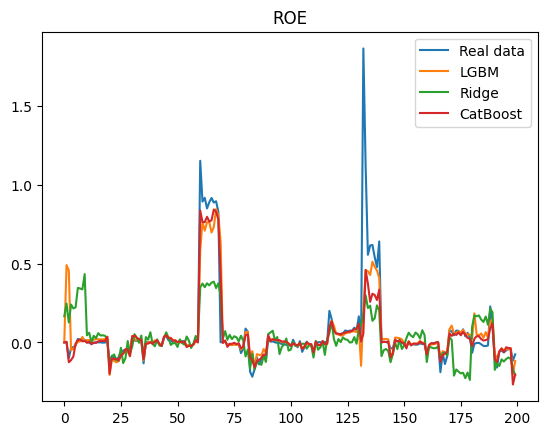

In [ ]:
plt.plot(y_test.reset_index(drop=True), label='Real data')
plt.plot(reg_roe_result_dataframe.iloc[-1, -1], label='LGBM')
plt.plot(reg_roe_result_dataframe.iloc[-3, -1], label='Ridge')
plt.plot(reg_roe_result_dataframe.iloc[-2, -1], label='CatBoost')
plt.legend()
plt.title('ROE');

### 4.1*. Regression for relative changes of ROE

#### 4.1.1*. BASELINE - No sentiment, no text, just raw history data
#### 4.1.2*. Add tokenizers
#### 4.1.3*. Add sentiment

### 4.2. Regression - ROA

In [ ]:
date_feature = 'date'
target_indicator = 'ROA'
scaler = StandardScaler()

df_roe_targets_reg = add_shifts_and_filter(df_indicators, target_indicator, multi_bank_series_feature='licence_num')
df_roe_targets_reg = df_roe_targets_reg.merge(df.loc[:, df.columns != target_indicator], how='left', on=['licence_num', 'date'])
df_roe_targets_reg['month'] = df_roe_targets_reg['date'].dt.month
df_roe_targets_reg['year'] = df_roe_targets_reg['date'].dt.year
df_roe_targets_reg[target_indicator] = scaler.fit_transform(df_roe_targets_reg[target_indicator].values.reshape(-1, 1))

banks_to_pred = df_roe_targets_reg.groupby('licence_num')['date'].count().sort_values().tail(20).index.to_list()
roe_data_test = df_roe_targets_reg[df_roe_targets_reg.licence_num.isin(banks_to_pred)].groupby('licence_num').tail(10)
roe_data_train = df_roe_targets_reg[~df_roe_targets_reg.index.isin(roe_data_test.index)]

cat_features = ['licence_num', 'msk_spb', 'default', 'month', 'year', 'day_of_week', 'n_reports']
num_features = roe_data_train.columns[~roe_data_train.columns.isin([date_feature, target_indicator, *cat_features])].tolist()

In [ ]:
# DataFrame for results
reg_roa_result_dataframe = get_result_dataframe()

scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown="ignore")
target_indicator = 'ROA'

X_train = roe_data_train.loc[:, ~roe_data_train.columns.isin([target_indicator, 'date'])]
y_train = roe_data_train[target_indicator]
X_test = roe_data_test.loc[:, ~roe_data_test.columns.isin([target_indicator, 'date'])]
y_test = roe_data_test[target_indicator]

models_dict, models_dict_reg = get_ml_models_reg(task_type='CPU')

for key in tqdm(models_dict.keys()):
    if key == 'LinearSVR' or key == 'SGDRegressor':
        continue
    column_transformer = ColumnTransformer([
        ('ohe', encoder, cat_features),
        ('scaler', scaler, num_features)], remainder='passthrough', n_jobs=-1)

    model = models_dict[key]
    pipe = Pipeline([
        ('transform', column_transformer),
        ('model', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
    dd['diff_y_pred'] = dd['y_pred'].diff()
    dd['diff_y_test'] = dd['y_test'].diff()
    dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
    dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

    res = round(mean_absolute_percentage_error(y_test, y_pred), 4)  # , accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
    reg_roa_result_dataframe = pd.concat([reg_roa_result_dataframe,
                                            pd.DataFrame({'sentiment': ['no sentiment'],
                                                          'tokenizer': ['no tokenizer'],
                                                          'model': [key],
                                                          'stock_or_indicator': [target_indicator],
                                                          'result': [res],
                                                          'predictions': [y_pred]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


#### 4.1.2. Add tokenizers

#### 4.1.3. Add sentiment

In [ ]:
df_news_filtered['month'] = df_news_filtered['date'].dt.month
df_news_filtered['year'] = df_news_filtered['date'].dt.year

dff1_sent_roe = dff1_sent.copy()
dff1_sent_roe['month'] = dff1_sent_roe['date'].dt.month
dff1_sent_roe['year'] = dff1_sent_roe['date'].dt.year
dff1_sent_roe = dff1_sent_roe.groupby(['year', 'month'], as_index=False)\
     .agg({'preds_proba': 'min'})\
     .rename(columns={'preds_proba': 'preds_proba_min'})\
     .merge(dff1_sent_roe.groupby(['year', 'month'], as_index=False).agg({'preds_proba': 'max'}), how='left', on=['year', 'month'])\
     .rename(columns={'preds_proba': 'preds_proba_max'})
dff1_sent_roe['sentiment'] = np.where(dff1_sent_roe['preds_proba_max'] >= dff1_sent_roe['preds_proba_min'].abs(),
                                      'positive', 'negative')

df_roe_targets_reg = df_roe_targets_reg.merge(dff1_sent_roe, how='left', on=['year', 'month'])
banks_to_pred = df_roe_targets_reg.groupby('licence_num')['date'].count().sort_values().tail(20).index.to_list()
roe_data_test = df_roe_targets_reg[df_roe_targets_reg.licence_num.isin(banks_to_pred)].groupby('licence_num').tail(10)
roe_data_train = df_roe_targets_reg[~df_roe_targets_reg.index.isin(roe_data_test.index)]

In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown="ignore")

X_train = roe_data_train.loc[:, ~roe_data_train.columns.isin([target_indicator, 'date'])]
y_train = roe_data_train[target_indicator]
X_test = roe_data_test.loc[:, ~roe_data_test.columns.isin([target_indicator, 'date'])]
y_test = roe_data_test[target_indicator]

models_dict, models_dict_reg = get_ml_models_reg(task_type='CPU', verb=False)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

for key in tqdm(models_dict.keys()):
    if key == 'LinearSVR' or key == 'SGDRegressor':
        continue
    column_transformer = ColumnTransformer([
        ('ohe1', encoder, ['sentiment']),
        ('ohe', encoder, cat_features),
        ('scaler', scaler, ['preds_proba_min', 'preds_proba_max', *num_features])], remainder='passthrough', n_jobs=-1)

    model = models_dict[key]
    pipe = Pipeline([
        ('transform', column_transformer),
        ('model', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
    dd['diff_y_pred'] = dd['y_pred'].diff()
    dd['diff_y_test'] = dd['y_test'].diff()
    dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
    dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

    res = round(mean_absolute_percentage_error(y_test, y_pred), 4)  # , accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
    reg_roa_result_dataframe = pd.concat([reg_roa_result_dataframe,
                                            pd.DataFrame({'sentiment': ['with sentiment'],
                                                          'tokenizer': ['no tokenizer'],
                                                          'model': [key],
                                                          'stock_or_indicator': [target_indicator],
                                                          'result': [res],
                                                          'predictions': [y_pred]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


In [ ]:
reg_roa_result_dataframe

,sentiment,tokenizer,model,stock_or_indicator,result,predictions
0,no sentiment,no tokenizer,Ridge,ROA,1.4226,"[0.014761613805846313, 0.3866555765663409, -0...."
1,no sentiment,no tokenizer,CatBoostRegressor,ROA,1.1359,"[0.013169578044346824, -1.261265187881425, -0...."
2,no sentiment,no tokenizer,LGBMRegressor,ROA,1.0447,"[-0.1660287994752517, -1.209963627961423, -0.2..."
3,with sentiment,no tokenizer,Ridge,ROA,1.4244,"[0.011922995476344539, 0.3867760572737081, -0...."
4,with sentiment,no tokenizer,CatBoostRegressor,ROA,1.0065,"[0.012062420077115344, -1.1732085240888344, -0..."
5,with sentiment,no tokenizer,LGBMRegressor,ROA,1.0022,"[-0.17124284621337246, -1.2615058571016475, -0..."


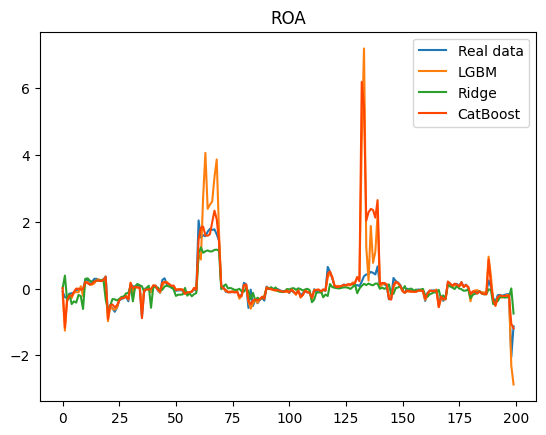

In [ ]:
plt.plot(y_test.reset_index(drop=True), label='Real data')
plt.plot(reg_roa_result_dataframe.iloc[-1, -1], label='LGBM')
plt.plot(reg_roa_result_dataframe.iloc[-3, -1], label='Ridge')
plt.plot(reg_roa_result_dataframe.iloc[-2, -1], label='CatBoost', color='orangered')
plt.legend()
plt.title('ROA');

### 4.2. Regression - Net Assets

In [ ]:
date_feature = 'date'
target_indicator = 'net_assets'
scaler = StandardScaler()

df_roe_targets_reg = add_shifts_and_filter(df_indicators, target_indicator, multi_bank_series_feature='licence_num')
df_roe_targets_reg = df_roe_targets_reg.merge(df.loc[:, df.columns != target_indicator], how='left', on=['licence_num', 'date'])
df_roe_targets_reg['month'] = df_roe_targets_reg['date'].dt.month
df_roe_targets_reg['year'] = df_roe_targets_reg['date'].dt.year
# df_roe_targets_reg[target_indicator] = scaler.fit_transform(df_roe_targets_reg[target_indicator].values.reshape(-1, 1))

banks_to_pred = df_roe_targets_reg.groupby('licence_num')['date'].count().sort_values().tail(20).index.to_list()[1]
roe_data_test = df_roe_targets_reg[df_roe_targets_reg.licence_num.isin([banks_to_pred])].tail(50)
roe_data_train = df_roe_targets_reg[~df_roe_targets_reg.index.isin(roe_data_test.index)]

cat_features = ['licence_num', 'msk_spb', 'default', 'month', 'year', 'day_of_week', 'n_reports']
num_features = roe_data_train.columns[~roe_data_train.columns.isin([date_feature, target_indicator, *cat_features])].tolist()

In [ ]:
# DataFrame for results
reg_na_result_dataframe = get_result_dataframe()

scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown="ignore")

X_train = roe_data_train.loc[:, ~roe_data_train.columns.isin([target_indicator, 'date'])]
y_train = roe_data_train[target_indicator]
X_test = roe_data_test.loc[:, ~roe_data_test.columns.isin([target_indicator, 'date'])]
y_test = roe_data_test[target_indicator]

models_dict, models_dict_reg = get_ml_models_reg(task_type='CPU')

for key in tqdm(models_dict.keys()):
    if key == 'LinearSVR' or key == 'SGDRegressor':
        continue
    column_transformer = ColumnTransformer([
        ('ohe', encoder, cat_features),
        ('scaler', scaler, num_features)], remainder='passthrough', n_jobs=-1)

    model = models_dict[key]
    pipe = Pipeline([
        ('transform', column_transformer),
        ('model', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
    dd['diff_y_pred'] = dd['y_pred'].diff()
    dd['diff_y_test'] = dd['y_test'].diff()
    dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
    dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

    res = round(mean_absolute_percentage_error(y_test, y_pred), 4)  # , accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
    reg_na_result_dataframe = pd.concat([reg_na_result_dataframe,
                                            pd.DataFrame({'sentiment': ['no sentiment'],
                                                          'tokenizer': ['no tokenizer'],
                                                          'model': [key],
                                                          'stock_or_indicator': [target_indicator],
                                                          'result': [res],
                                                          'predictions': [y_pred]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:31<00:00,  6.31s/it]


#### 4.1.2. Add tokenizers

#### 4.1.3. Add sentiment

In [ ]:
df_news_filtered['month'] = df_news_filtered['date'].dt.month
df_news_filtered['year'] = df_news_filtered['date'].dt.year

dff1_sent_roe = dff1_sent.copy()
dff1_sent_roe['month'] = dff1_sent_roe['date'].dt.month
dff1_sent_roe['year'] = dff1_sent_roe['date'].dt.year
dff1_sent_roe = dff1_sent_roe.groupby(['year', 'month'], as_index=False)\
     .agg({'preds_proba': 'min'})\
     .rename(columns={'preds_proba': 'preds_proba_min'})\
     .merge(dff1_sent_roe.groupby(['year', 'month'], as_index=False).agg({'preds_proba': 'max'}), how='left', on=['year', 'month'])\
     .rename(columns={'preds_proba': 'preds_proba_max'})
# dff1_sent_roe = dff1_sent_roe.groupby(['year', 'month'], as_index=False).agg({'preds_proba': 'mean'})
dff1_sent_roe['sentiment'] = np.where(dff1_sent_roe['preds_proba_max'] >= dff1_sent_roe['preds_proba_min'].abs(),
                                      'positive', 'negative')
# dff1_sent_roe = dff1_sent_roe.drop(columns=['preds_proba'])


df_roe_targets_reg = df_roe_targets_reg.merge(dff1_sent_roe, how='left', on=['year', 'month'])
banks_to_pred = df_roe_targets_reg.groupby('licence_num')['date'].count().sort_values().tail(20).index.to_list()[1]
roe_data_test = df_roe_targets_reg[df_roe_targets_reg.licence_num.isin([banks_to_pred])].tail(47)
roe_data_train = df_roe_targets_reg[~df_roe_targets_reg.index.isin(roe_data_test.index)]


In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown="ignore")

X_train = roe_data_train.loc[:, ~roe_data_train.columns.isin([target_indicator, 'date'])]
y_train = roe_data_train[target_indicator]
X_test = roe_data_test.loc[:, ~roe_data_test.columns.isin([target_indicator, 'date'])]
y_test = roe_data_test[target_indicator]

models_dict, models_dict_reg = get_ml_models_reg(task_type='CPU', verb=False)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

for key in tqdm(models_dict.keys()):
    if key == 'LinearSVR' or key == 'SGDRegressor':
        continue
    column_transformer = ColumnTransformer([
        ('ohe1', encoder, ['sentiment']),
        ('ohe', encoder, cat_features),
        ('scaler', scaler, ['preds_proba_min', 'preds_proba_max', *num_features])], remainder='passthrough', n_jobs=-1)

    model = models_dict[key]
    pipe = Pipeline([
        ('transform', column_transformer),
        ('model', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    dd = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test.reset_index(drop=True)})
    dd['diff_y_pred'] = dd['y_pred'].diff()
    dd['diff_y_test'] = dd['y_test'].diff()
    dd['diff_y_pred_cat'] = np.where(dd['diff_y_pred'] > 0, 'up', 'down')
    dd['diff_y_test_cat'] = np.where(dd['diff_y_test'] > 0, 'up', 'down')

    res = round(mean_absolute_percentage_error(y_test, y_pred), 4)  # , accuracy_score(dd['diff_y_pred_cat'], dd['diff_y_test_cat'])
    reg_na_result_dataframe = pd.concat([reg_na_result_dataframe,
                                            pd.DataFrame({'sentiment': ['with sentiment'],
                                                          'tokenizer': ['no tokenizer'],
                                                          'model': [key],
                                                          'stock_or_indicator': [target_indicator],
                                                          'result': [res],
                                                          'predictions': [y_pred]})], axis=0, ignore_index=True)

100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


In [ ]:
reg_na_result_dataframe

,sentiment,tokenizer,model,stock_or_indicator,result,predictions
0,no sentiment,no tokenizer,Ridge,net_assets,0.8299,"[5554050.155598342, 6099918.300352782, 4281344..."
1,no sentiment,no tokenizer,CatBoostRegressor,net_assets,0.3096,"[3987593.8355591595, 2829092.8155112267, 35611..."
2,no sentiment,no tokenizer,LGBMRegressor,net_assets,0.3067,"[3842657.8948820364, 3791879.8233870855, 40822..."
3,with sentiment,no tokenizer,Ridge,net_assets,0.7776,"[2708706.165269062, 4163839.3279128373, 591769..."
4,with sentiment,no tokenizer,CatBoostRegressor,net_assets,0.3809,"[3957923.3958934993, 4290979.05786334, 4124861..."
5,with sentiment,no tokenizer,LGBMRegressor,net_assets,0.2817,"[3015393.244142773, 3491497.23655941, 3431708...."


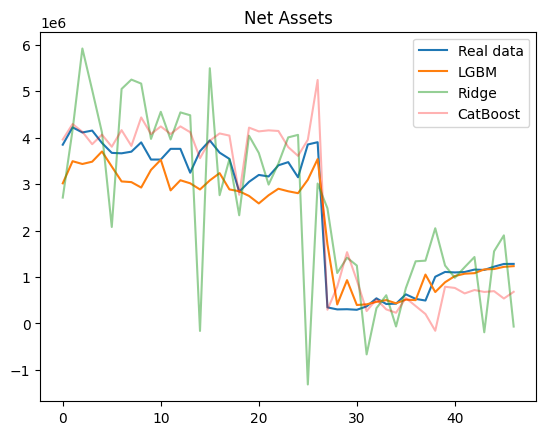

In [ ]:
plt.plot(y_test.reset_index(drop=True), label='Real data')
plt.plot(reg_na_result_dataframe.iloc[-1, -1], label='LGBM')
plt.plot(reg_na_result_dataframe.iloc[-3, -1], label='Ridge', alpha=0.5)
plt.plot(reg_na_result_dataframe.iloc[-2, -1], label='CatBoost', color='red', alpha=0.3)
plt.legend()
plt.title('Net Assets');

### 4.2*. Regression for relative changes of Net Assets
#### 4.2.1*. BASELINE - No sentiment, no text, just raw history data
#### 4.2.2*. Add tokenizers
#### 4.2.3*. Add sentiment

In [ ]:
reg_indicator_result_dataframe = pd.concat([reg_roe_result_dataframe, reg_roa_result_dataframe], axis=0, ignore_index=True)
reg_indicator_result_dataframe = pd.concat([reg_indicator_result_dataframe, reg_na_result_dataframe], axis=0, ignore_index=True)
reg_indicator_result_dataframe

pd.pivot_table(reg_indicator_result_dataframe, values='result', index=['model', 'stock_or_indicator'], columns='sentiment', aggfunc='first', sort=False)

sentiment                             no sentiment  with sentiment
model             stock_or_indicator                              
Ridge             ROE                      15.8534         12.8899
                  ROA                       1.4226          1.4244
                  net_assets                0.8299          0.7776
CatBoostRegressor ROE                       6.2485          5.4470
                  ROA                       1.1359          1.0065
                  net_assets                0.3096          0.3809
LGBMRegressor     ROE                      11.6617         10.3924
                  ROA                       1.0447          1.0022
                  net_assets                0.3067          0.2817